# Titanic Kaggle Competition #

Titanic was a catastrophe

### Setup

In [258]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


train_data_loc = "./titanic_data/train.csv"
test_data_loc = "./titanic_data/test.csv"

train_data = pd.read_csv(train_data_loc, index_col="PassengerId")
test_data = pd.read_csv(test_data_loc, index_col="PassengerId")
full_data = pd.concat([train_data, test_data])
print("Train data shape:    ", train_data.shape)
print("Test data shape:     ", test_data.shape)
print("Full data shape:     ", full_data.shape)

plt.rc("figure" , figsize=(14,6), autolayout=True)
plt.rc("axes", grid=True)
plt.rc("grid", alpha=0.5)

Train data shape:     (891, 11)
Test data shape:      (418, 10)
Full data shape:      (1309, 11)


## Exploratory Data Analysis

### Obtaining basic understanding and cleaning up the data

Firstly the data should be inspected

In [259]:
full_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The name column might include some useful information. Not in form of names and surnames but as a title.

In [260]:
full_data["Title"] = full_data["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
full_data["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

Upon further inspection it was decided that titles should be grouped into categories. Such titles as "Mrs", "Dona" or "Ms" are basically equivalent to each other and simply indicate the sex of the observation and if she or he was married. Other titles like "Countess" or "Lady" indicate that the observation was from some kind of royal family, and so on.

In [261]:
full_data["Title"] = full_data["Title"].replace("Mlle", "Miss")
full_data["Title"] = full_data["Title"].replace(["Mme", "Dona", "Ms"], "Mrs")
full_data["Title"] = full_data["Title"].replace("Don", "Mr")
full_data["Title"] = full_data["Title"].replace(["Capt", "Major", "Col"], "Military")
full_data["Title"] = full_data["Title"].replace(["Countess" ,"Lady", "Sir", "Jonkheer"], "Royalty")

In [262]:
full_data["Title"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr', 'Military', 'Royalty'],
      dtype=object)

train_data and test_data won't be yet reassigned as there are some values missing in the set that will need further manipulations.

In [263]:
train_data.info()
print("-" * 40)
test_data.info()
print("-" * 40)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 n

In [264]:
print(pd.isna(full_data).sum())

Survived     418
Pclass         0
Name           0
Sex            0
Age          263
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
Title          0
dtype: int64


We can see that there are 418 missing values in the "Survived" column in the whole data set. This is the exact number of observations in the test.csv file, which does not include this information at all. As such this should be ignored. Next glaring issue is that the "Cabin" column is almost empty, so it should be omitted in further analysis. Also "Ticket" seems to be just the ID of the ticket which isn't useful. However, missing values of "Age", "Fare" and "Embarked" can be easily fixed without influencing the analysis too much, while maintaining other information corresponding to the observation with missing values.

In [265]:
full_data = full_data.drop("Cabin", axis=1)
full_data = full_data.drop("Ticket", axis=1)

full_data["Embarked"] = full_data["Embarked"].fillna(full_data["Embarked"].mode().iloc[0])
full_data["Fare"] = full_data["Fare"].fillna(full_data["Fare"].mode().iloc[0])

To impute age the title of the observation was taken into consideration. If an observation is an infant or a child it won't have a title of Mister or Reverend.

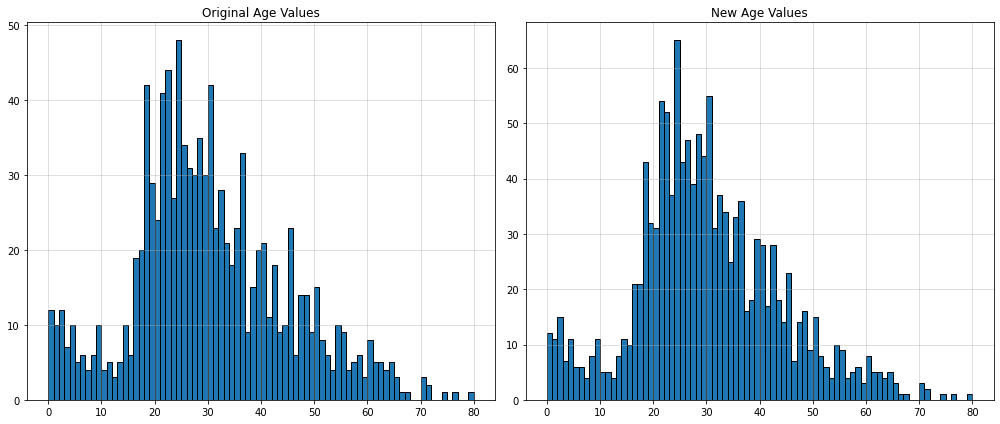

In [266]:
# Two plots will be drawn to compare new values with the old ones
fig_0, ax = plt.subplots(1, 2)
ax[0].set_title("Original Age Values")
ax[1].set_title("New Age Values")
# Draw plot of old values
ax[0].hist(full_data["Age"].dropna().astype(int), edgecolor="black", bins=80)


titles = [title for title in full_data["Title"].unique()]
for title in titles:
   # Calculate average age and std of each group of objects with same title
   avg_age_of_title = full_data.loc[(full_data["Age"].notna()) & (full_data["Title"] == title), "Age"].mean()
   std_age_of_title = full_data.loc[(full_data["Age"].notna()) & (full_data["Title"] == title), "Age"].std()
   # Get series with null ages with same title
   age_is_nan_of_title_series = full_data.loc[(full_data["Age"].isnull()) & (full_data["Title"] == title), "Age"]
   # Calculate a random int between avg - std and avg + std

   rand_age_of_title = np.random.uniform(avg_age_of_title - std_age_of_title, avg_age_of_title + std_age_of_title, size=age_is_nan_of_title_series.isnull().sum())

   full_data.loc[(full_data["Age"].isnull()) & (full_data["Title"] == title), "Age"] = rand_age_of_title

# Draw plot of new values
ax[1].hist(full_data["Age"].astype(int), bins=80, edgecolor="black");

Now that the missing values have been fixed I'd like to map categorical data into numerical one.

In [267]:
# Simple mapping of sex
full_data["Sex"] = full_data["Sex"].map({"male": 0, "female": 1})

# Hot-one encoding for "Embarked" and "Title"
embarked_dummies = pd.get_dummies(full_data["Embarked"])
title_dummies = pd.get_dummies(full_data["Title"])

# Concat the hot-one encoding and drop categorical data and unused data
full_data = pd.concat([full_data, title_dummies, embarked_dummies], axis=1)
full_data = full_data.drop(["Name", "Embarked", "Title"], axis=1)

Lastly I'd like to change some of the dtypes. There is no need for "Age", "Fare" and "Survived" to be a float. The differences are too small and models handle ints better

In [268]:
full_data.dtypes

Survived    float64
Pclass        int64
Sex           int64
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Dr            uint8
Master        uint8
Military      uint8
Miss          uint8
Mr            uint8
Mrs           uint8
Rev           uint8
Royalty       uint8
C             uint8
Q             uint8
S             uint8
dtype: object

In [269]:
full_data["Age"] = full_data["Age"].astype(int)
full_data["Fare"] = full_data["Fare"].astype(int)

In [270]:
train_data = full_data.loc[:891]
test_data = full_data.loc[892:]

train_data["Survived"] = train_data["Survived"].astype(int)

<ipython-input-270-fac0ccdde6fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Survived"] = train_data["Survived"].astype(int)


In [271]:
train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Dr,Master,Military,Miss,Mr,Mrs,Rev,Royalty,C,Q,S
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.599327,0.523008,0.381594,31.785634,0.007856,0.044893,0.005612,0.206510,0.581369,0.142536,0.006734,0.004489,0.188552,0.086420,0.725028
std,0.486592,0.836071,0.477990,13.577491,1.102743,0.806057,49.703730,0.088337,0.207186,0.074743,0.405028,0.493612,0.349796,0.081830,0.066890,0.391372,0.281141,0.446751
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,37.500000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [272]:
test_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Dr,Master,Military,Miss,Mr,Mrs,Rev,Royalty,C,Q,S
count,0.0,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000,418.000000
mean,NaN,2.265550,0.363636,29.820574,0.447368,0.392344,35.119617,0.002392,0.050239,0.004785,0.186603,0.574163,0.177033,0.004785,0.0,0.244019,0.110048,0.645933
std,NaN,0.841838,0.481622,13.409394,0.896760,0.981429,55.862069,0.048912,0.218700,0.069088,0.390059,0.495062,0.382154,0.069088,0.0,0.430019,0.313324,0.478803
min,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,NaN,1.000000,0.000000,22.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,NaN,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
75%,NaN,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000
max,NaN,3.000000,1.000000,76.000000,8.000000,9.000000,512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [273]:
full_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Dr,Master,Military,Miss,Mr,Mrs,Rev,Royalty,C,Q,S
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,2.294882,0.355997,29.669977,0.498854,0.385027,32.850267,0.006112,0.046600,0.005348,0.200153,0.579068,0.153552,0.006112,0.003056,0.206264,0.093965,0.699771
std,0.486592,0.837836,0.478997,13.519310,1.041658,0.865560,51.751809,0.077967,0.210862,0.072959,0.400267,0.493897,0.360657,0.077967,0.055216,0.404777,0.291891,0.458533
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,28.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,9.000000,512.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This gives us some interesting information:
   - most people embarked in Southampton
   - the passengers were mostly male
   - the passengers were rather young with mean being 29.9 and std 14.4
   - there were quite a few families abroad

First thing that comes to mind in a shipwreck disaster is whether the famous "women and children first rule" was adhered to.

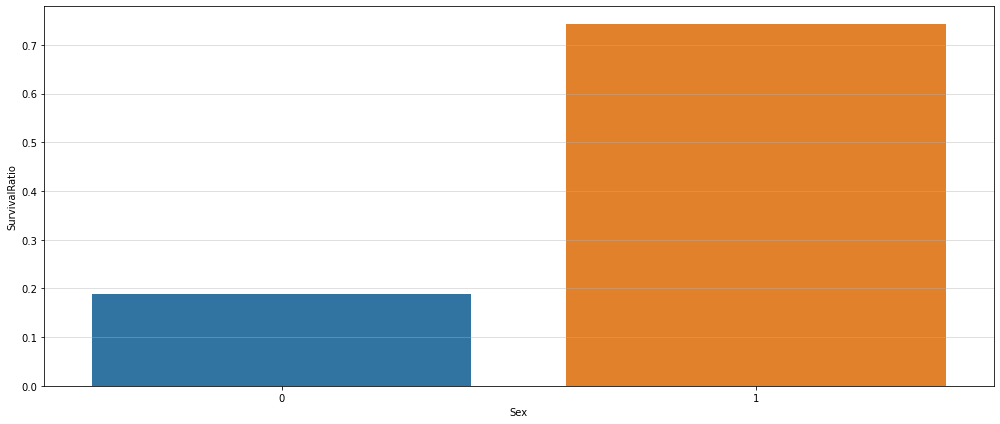

In [274]:
sex_features = ["Sex", "Survived"]
sex_data = train_data.loc[:, sex_features]
sex_data["Total"] = 1
sex_data = sex_data.groupby("Sex").sum()
sex_data["SurvivalRatio"] = sex_data["Survived"] / sex_data["Total"]

sns.barplot(x=sex_data.index, y=sex_data["SurvivalRatio"]);

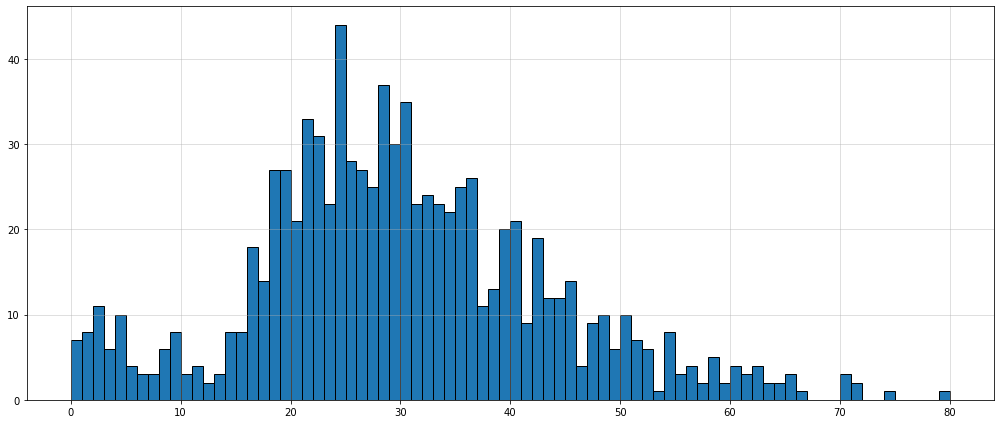

In [275]:
plt.hist(train_data["Age"], bins=80, edgecolor="black");

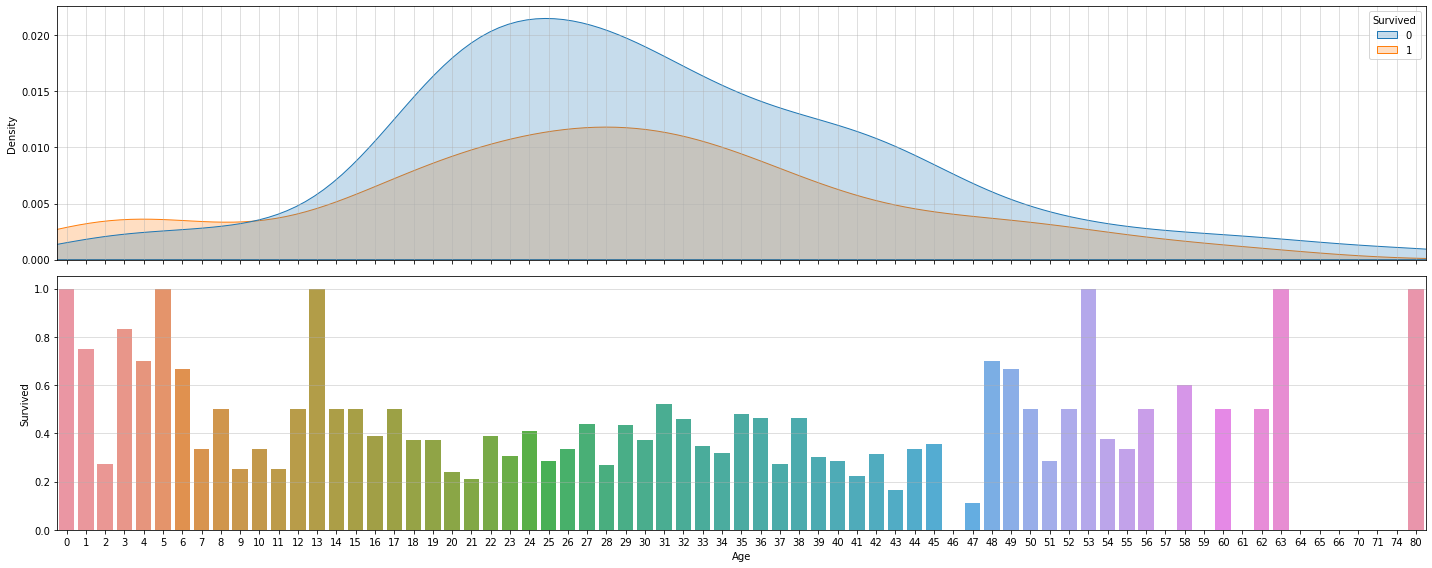

In [276]:
fig_1, ax = plt.subplots(2, 1, figsize=(20, 8), sharex="all")

mean_survived_per_age = train_data[["Age", "Survived"]].groupby("Age", as_index=False).mean()

sns.kdeplot(x="Age", shade=True, data=train_data, hue="Survived", ax=ax[0])
sns.barplot(x="Age", y="Survived", data=mean_survived_per_age, ax=ax[1]);

We can see that women, children and elderly clearly have higher survival rates.

Next thing that interests me is how class of ticket and fares impacted survival. The histogram was limited to a fare of 100 to improve visibility. There are some observations that have their fare a lot higher but there are few of them.

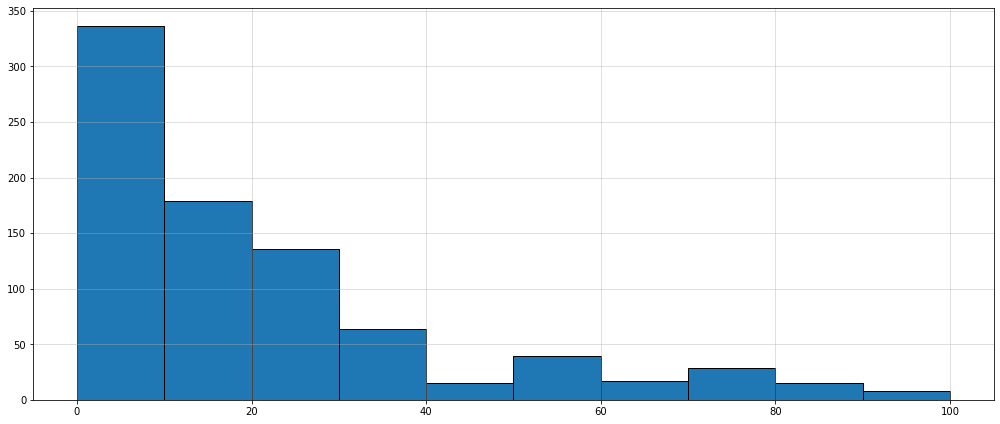

In [277]:
plt.hist(train_data["Fare"], bins=10, range=(0, 100), edgecolor="black");

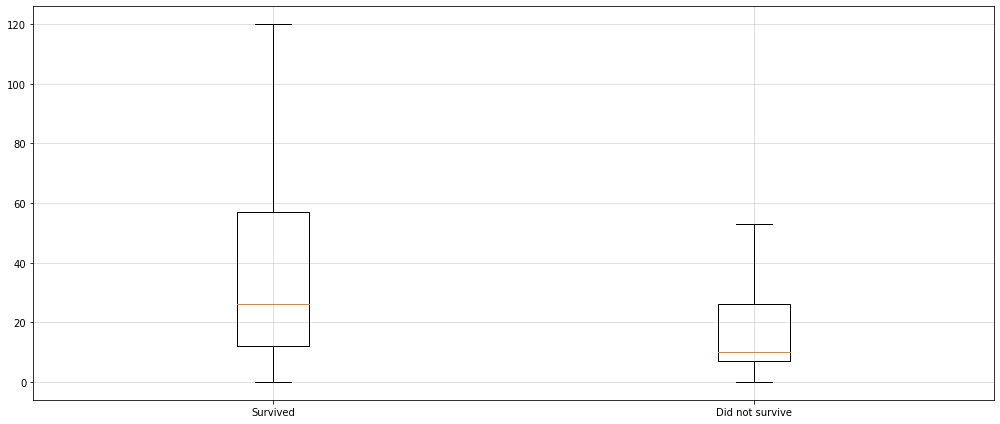

In [278]:
fare_survived = train_data.loc[(train_data["Survived"] == 1), "Fare"]
fare_not_survived = train_data.loc[(train_data["Survived"] == 0), "Fare"]
plt.boxplot(x=[fare_survived, fare_not_survived], labels=["Survived", "Did not survive"], showfliers=False);

People who payed more had a larger chance of survival. It is probably closely related to class of ticket

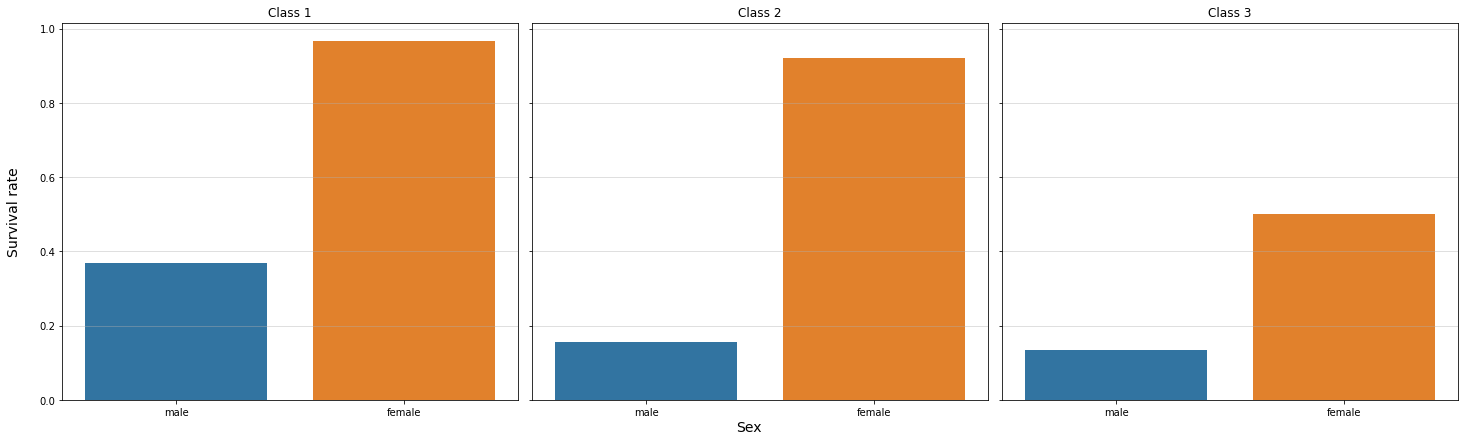

In [279]:
fig_2, ax = plt.subplots(1, 3, figsize=(20, 6), sharey="all")

for i in range(3):
   df = train_data.loc[(train_data["Pclass"] == i + 1), ["Survived", "Sex"]].groupby("Sex", as_index=False).mean()
   ax[i].set_title(f"Class {i + 1}")
   sns.barplot(x=df["Sex"], y=df["Survived"], ax=ax[i])
   ax[i].set_xticklabels(["male", "female"])
   ax[i].set_xlabel(None)
   ax[i].set_ylabel(None)

fig_2.text(0.5, 0.0, "Sex", fontsize=14, ha="center", va="center")
fig_2.text(-0.01, 0.5, "Survival rate", fontsize=14, ha="center", va="center", rotation='vertical');

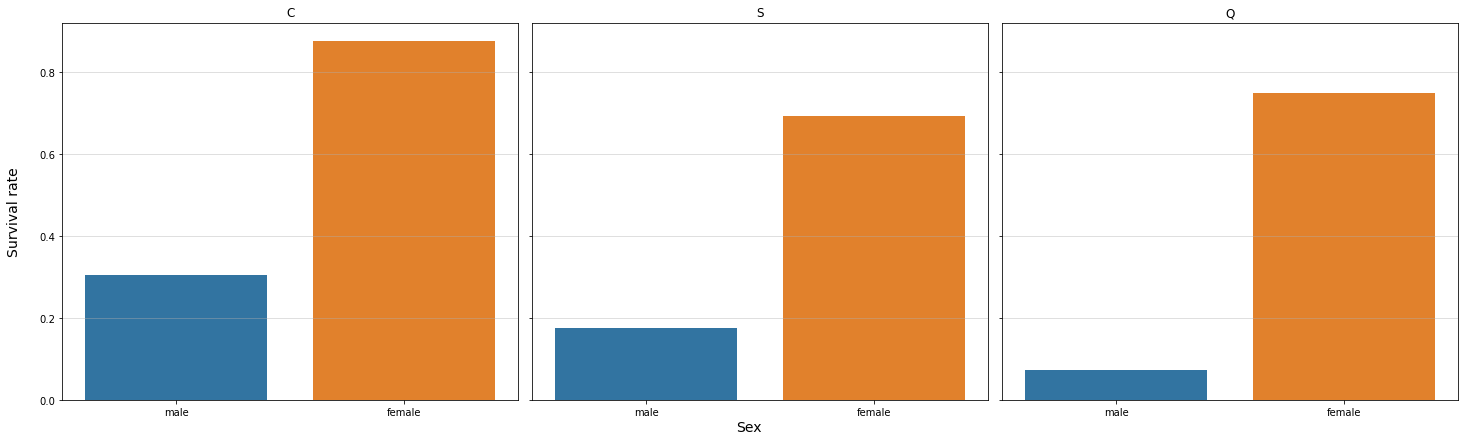

In [280]:
fig_3, ax = plt.subplots(1, 3, figsize=(20, 6), sharey="all")

embarked = ["C", "S", "Q"]
for i, place in enumerate(embarked):
   df = train_data.loc[(train_data[place] == 1), ["Survived", "Sex"]].groupby("Sex", as_index=False).mean()
   ax[i].set_title(place)
   sns.barplot(x=df["Sex"], y=df["Survived"], ax=ax[i])
   ax[i].set_xticklabels(["male", "female"])
   ax[i].set_xlabel(None)
   ax[i].set_ylabel(None)

fig_3.text(0.5, 0.0, "Sex", fontsize=14, ha="center", va="center")
fig_3.text(-0.01, 0.5, "Survival rate", fontsize=14, ha="center", va="center", rotation='vertical');

Next siblings and spouses

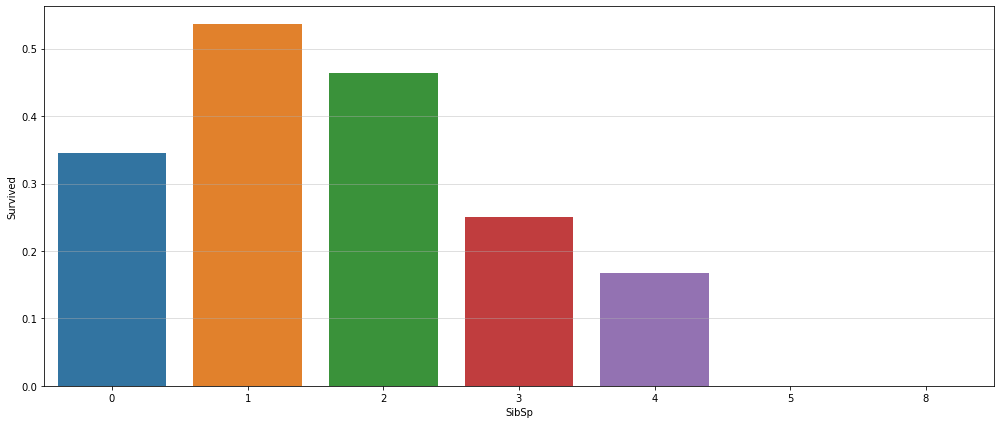

In [281]:
sib_sp = pd.DataFrame(train_data.groupby("SibSp", as_index=False)["Survived"].mean())
sns.barplot(x=sib_sp["SibSp"], y=sib_sp["Survived"]);

Parents and children

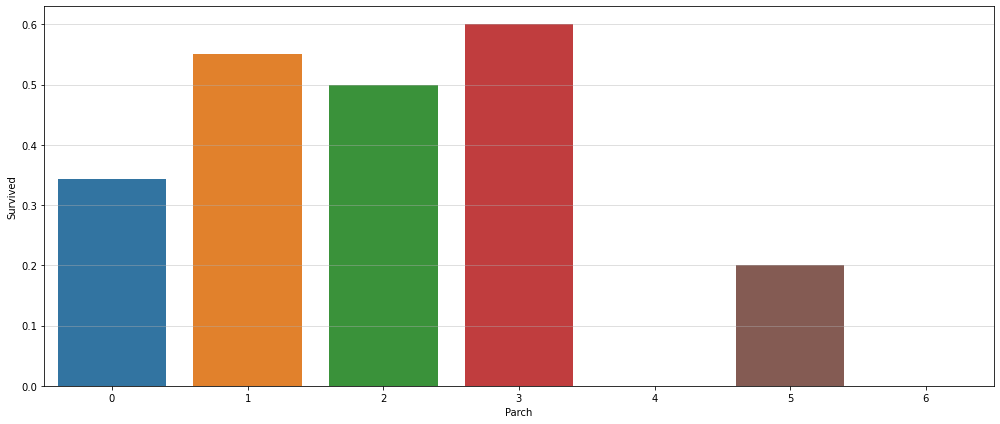

In [282]:
parch = pd.DataFrame(train_data.groupby("Parch", as_index=False)["Survived"].mean())
sns.barplot(x=parch["Parch"], y=parch["Survived"]);

Although this data differs a bit in my opinion it could be combined into one that tells us whether the passenger was travelling with family or not.

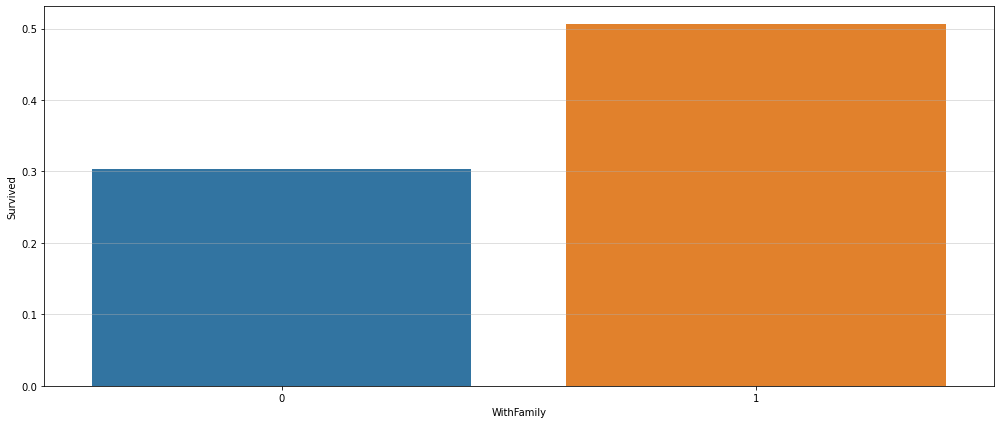

In [283]:
train_data = train_data.assign(WithFamily=(train_data["SibSp"] + train_data["Parch"]))
train_data.loc[train_data["WithFamily"] > 0, "WithFamily"] = 1
train_data = train_data.drop(["SibSp", "Parch"], axis=1)

test_data = test_data.assign(WithFamily=(test_data["SibSp"] + test_data["Parch"]))
test_data.loc[test_data["WithFamily"] > 0, "WithFamily"] = 1
test_data = test_data.drop(["SibSp", "Parch"], axis=1)


with_family = pd.DataFrame(train_data.groupby("WithFamily", as_index=False)["Survived"].mean())
sns.barplot(x=with_family["WithFamily"], y=with_family["Survived"]);

Lastly I want to analyze if being in a certain title group improved chances of survival

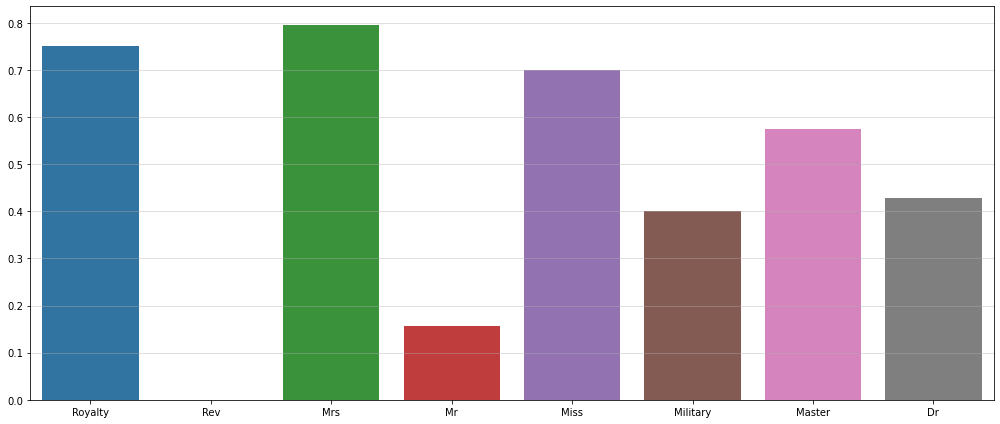

In [284]:
titles = ["Dr", "Master", "Military", "Miss", "Mr", "Mrs", "Rev", "Royalty"]
mean_survived_per_title = train_data[["Survived", *titles]].groupby(titles, as_index=False).mean()

survival_rate = []
for i in range(len(titles)):
   survival_rate.append(mean_survived_per_title.loc[i, "Survived"])
survival_rate_per_title = pd.Series(survival_rate, index=reversed(titles))
sns.barplot(x=survival_rate_per_title.index, y=survival_rate_per_title.values);

In [285]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Dr,Master,Military,Miss,Mr,Mrs,Rev,Royalty,C,Q,S,WithFamily
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,0,22,7,0,0,0,0,1,0,0,0,0,0,1,1
2,1,1,1,38,71,0,0,0,0,0,1,0,0,1,0,0,1
3,1,3,1,26,7,0,0,0,1,0,0,0,0,0,0,1,0
4,1,1,1,35,53,0,0,0,0,0,1,0,0,0,0,1,1
5,0,3,0,35,8,0,0,0,0,1,0,0,0,0,0,1,0


In [286]:
test_data.head()

,Survived,Pclass,Sex,Age,Fare,Dr,Master,Military,Miss,Mr,Mrs,Rev,Royalty,C,Q,S,WithFamily
PassengerId,,,,,,,,,,,,,,,,,
892,NaN,3,0,34,7,0,0,0,0,1,0,0,0,0,1,0,0
893,NaN,3,1,47,7,0,0,0,0,0,1,0,0,0,0,1,1
894,NaN,2,0,62,9,0,0,0,0,1,0,0,0,0,1,0,0
895,NaN,3,0,27,8,0,0,0,0,1,0,0,0,0,0,1,0
896,NaN,3,1,22,12,0,0,0,0,0,1,0,0,0,0,1,1


In [287]:
train_data = train_data.drop(["Mr", "S", "Dr", "Master", "Military", "Miss", "Mrs", "Rev", "Royalty"], axis=1)
test_data = test_data.drop(["Mr", "S", "Dr", "Master", "Military", "Miss", "Mrs", "Rev", "Royalty"], axis=1)

In [288]:
pclass_dummies = pd.get_dummies(train_data.Pclass, dtype=int, prefix="Class")
test_pclass_dummies = pd.get_dummies(test_data.Pclass, dtype=int, prefix="Class")
train_data = pd.concat([train_data, pclass_dummies], axis=1)
test_data = pd.concat([test_data, test_pclass_dummies], axis=1)

train_data = train_data.drop(["Pclass", "Class_3"], axis=1)
test_data = test_data.drop(["Pclass", "Class_3"], axis=1)

## Machine Learning Models

In [289]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"]

X_test = test_data.drop("Survived", axis=1)

In [290]:
X_train.head()

,Sex,Age,Fare,C,Q,WithFamily,Class_1,Class_2
PassengerId,,,,,,,,
1,0,22,7,0,0,1,0,0
2,1,38,71,1,0,1,1,0
3,1,26,7,0,0,0,0,0
4,1,35,53,0,0,1,1,0
5,0,35,8,0,0,0,0,0


In [291]:
X_test.head()

,Sex,Age,Fare,C,Q,WithFamily,Class_1,Class_2
PassengerId,,,,,,,,
892,0,34,7,0,1,0,0,0
893,1,47,7,0,0,1,0,0
894,0,62,9,0,1,0,0,1
895,0,27,8,0,0,0,0,0
896,1,22,12,0,0,1,0,0


In [292]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_minmax = X_train
X_train_minmax[["Age", "Fare"]] = min_max_scaler.fit_transform(X_train[["Age", "Fare"]])
X_test_minmax = X_test
X_test_minmax[["Age", "Fare"]] = min_max_scaler.fit_transform(X_test[["Age", "Fare"]])

In [293]:
X_train_minmax.head()

,Sex,Age,Fare,C,Q,WithFamily,Class_1,Class_2
PassengerId,,,,,,,,
1,0,0.2750,0.013672,0,0,1,0,0
2,1,0.4750,0.138672,1,0,1,1,0
3,1,0.3250,0.013672,0,0,0,0,0
4,1,0.4375,0.103516,0,0,1,1,0
5,0,0.4375,0.015625,0,0,0,0,0


In [294]:
# Logistic regression

log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train_minmax, y_train)

prediction = log_reg.predict(X_test)

log_reg.score(X_train_minmax, y_train)

0.7968574635241302

In [295]:
coeff_df = pd.DataFrame(train_data.columns.delete(0))
coeff_df.columns = ["Feature"]
coeff_df["Coefficient Estimate"] = pd.Series(log_reg.coef_[0])
coeff_df

,Feature,Coefficient Estimate
0,Sex,2.454201
1,Age,-1.926448
2,Fare,0.252371
3,C,0.541114
4,Q,0.388002
5,WithFamily,-0.018784
6,Class_1,1.987343
7,Class_2,1.165904


In [296]:
submission = pd.DataFrame({
   "PassengerId": test_data.index,
   "Survived": prediction
})
submission.to_csv("G:\\Programowanie\\ML\\titanic_kaggle\\titanic_submission.csv", index=False)